# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook reads all gene correlations across all chromosomes and computes a single correlation matrix by assembling a big correlation matrix with all genes.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene
from correlations import check_pos_def, compare_matrices, correct_corr_mat, adjust_non_pos_def

# Settings

In [3]:
# a cohort name (it could be something like UK_BIOBANK, etc)
COHORT_NAME = None

# reference panel such as 1000G or GTEX_V8
REFERENCE_PANEL = None

# predictions models such as MASHR or ELASTIC_NET
EQTL_MODEL = None

In [4]:
# Parameters
COHORT_NAME = "phenomexcan_astle"
REFERENCE_PANEL = "GTEX_V8"
EQTL_MODEL = "MASHR"


In [5]:
assert COHORT_NAME is not None and len(COHORT_NAME) > 0, "A cohort name must be given"

COHORT_NAME = COHORT_NAME.lower()
display(f"Cohort name: {COHORT_NAME}")

'Cohort name: phenomexcan_astle'

In [6]:
assert (
    REFERENCE_PANEL is not None and len(REFERENCE_PANEL) > 0
), "A reference panel must be given"

display(f"Reference panel: {REFERENCE_PANEL}")

'Reference panel: GTEX_V8'

In [7]:
assert (
    EQTL_MODEL is not None and len(EQTL_MODEL) > 0
), "A prediction/eQTL model must be given"

display(f"eQTL model: {EQTL_MODEL})")

'eQTL model: MASHR)'

In [8]:
OUTPUT_DIR_BASE = (
    conf.RESULTS["GLS"]
    / "gene_corrs"
    / "cohorts"
    / COHORT_NAME
    / REFERENCE_PANEL.lower()
    / EQTL_MODEL.lower()
)
OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/gtex_v8/mashr'

In [9]:
INPUT_DIR = OUTPUT_DIR_BASE / "by_chr"

display(f"Gene correlations input dir: {INPUT_DIR}")
assert INPUT_DIR.exists()

'Gene correlations input dir: /project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/gtex_v8/mashr/by_chr'

# Load data

## Gene correlations

In [10]:
all_gene_corr_files = list(INPUT_DIR.glob("gene_corrs-chr*.pkl"))

In [11]:
# sort by chromosome
all_gene_corr_files = sorted(
    all_gene_corr_files, key=lambda x: int(x.name.split("-chr")[1].split(".pkl")[0])
)

In [12]:
len(all_gene_corr_files)

22

In [13]:
all_gene_corr_files

[PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/gtex_v8/mashr/by_chr/gene_corrs-chr1.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/gtex_v8/mashr/by_chr/gene_corrs-chr2.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/gtex_v8/mashr/by_chr/gene_corrs-chr3.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/gtex_v8/mashr/by_chr/gene_corrs-chr4.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/gtex_v8/mashr/by_chr/gene_corrs-chr5.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/gtex_v8/mashr/by_chr/gene_corrs-chr6.pkl'),
 PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/g

In [14]:
assert len(all_gene_corr_files) == 22

## Get common genes

In [15]:
gene_ids = set()
for f in all_gene_corr_files:
    chr_genes = pd.read_pickle(f).index.tolist()
    gene_ids.update(chr_genes)

In [16]:
display(len(gene_ids))

6450

In [17]:
sorted(list(gene_ids))[:5]

['ENSG00000000419',
 'ENSG00000000938',
 'ENSG00000000971',
 'ENSG00000001084',
 'ENSG00000001167']

## Gene info

In [18]:
genes_info = pd.read_pickle(OUTPUT_DIR_BASE / "genes_info.pkl")

In [19]:
genes_info.shape

(6450, 7)

In [20]:
genes_info.head()

,name,id,chr,band,start_position,end_position,gene_length
0,FBXO34,ENSG00000178974,14,14q22.3,55271421,55361918,90497
1,ARG1,ENSG00000118520,6,6q23.2,131573144,131584332,11188
2,FADS2,ENSG00000134824,11,11q12.2,61792980,61867354,74374
3,CA4,ENSG00000167434,17,17q23.1,60149942,60170899,20957
4,PFKFB3,ENSG00000170525,10,10p15.1,6144934,6254644,109710


In [21]:
# keep genes in correlation matrices only
genes_info = genes_info[genes_info["id"].isin(gene_ids)]

In [22]:
genes_info.shape

(6450, 7)

In [23]:
assert not genes_info.isna().any(None)

In [24]:
genes_info.dtypes

name              object
id                object
chr                int64
band              object
start_position     int64
end_position       int64
gene_length        int64
dtype: object

In [25]:
genes_info.head()

,name,id,chr,band,start_position,end_position,gene_length
0,FBXO34,ENSG00000178974,14,14q22.3,55271421,55361918,90497
1,ARG1,ENSG00000118520,6,6q23.2,131573144,131584332,11188
2,FADS2,ENSG00000134824,11,11q12.2,61792980,61867354,74374
3,CA4,ENSG00000167434,17,17q23.1,60149942,60170899,20957
4,PFKFB3,ENSG00000170525,10,10p15.1,6144934,6254644,109710


# Create full correlation matrix

In [26]:
genes_info = genes_info.sort_values(["chr", "start_position"])

In [27]:
genes_info

,name,id,chr,band,start_position,end_position,gene_length
2028,NOC2L,ENSG00000188976,1,1p36.33,944203,959309,15106
5986,HES4,ENSG00000188290,1,1p36.33,998962,1000172,1210
2308,ISG15,ENSG00000187608,1,1p36.33,1001138,1014540,13402
6149,AGRN,ENSG00000188157,1,1p36.33,1020120,1056118,35998
5093,TNFRSF18,ENSG00000186891,1,1p36.33,1203508,1206592,3084
...,...,...,...,...,...,...,...
3409,CPT1B,ENSG00000205560,22,22q13.33,50568861,50578465,9604
5623,CHKB,ENSG00000100288,22,22q13.33,50578949,50601455,22506
5972,MAPK8IP2,ENSG00000008735,22,22q13.33,50600793,50613981,13188
151,ARSA,ENSG00000100299,22,22q13.33,50622754,50628173,5419


In [28]:
full_corr_matrix = pd.DataFrame(
    np.zeros((genes_info.shape[0], genes_info.shape[0])),
    index=genes_info["id"].tolist(),
    columns=genes_info["id"].tolist(),
)

In [29]:
assert full_corr_matrix.index.is_unique & full_corr_matrix.columns.is_unique

In [30]:
for chr_corr_file in all_gene_corr_files:
    print(chr_corr_file.name, flush=True, end="... ")

    # get correlation matrix for this chromosome
    corr_data = pd.read_pickle(chr_corr_file)

    # save gene correlation matrix
    full_corr_matrix.loc[corr_data.index, corr_data.columns] = corr_data

    # save inverse of Cholesky decomposition of gene correlation matrix
    # first, adjust correlation matrix if it is not positive definite
    is_pos_def = check_pos_def(corr_data)

    if is_pos_def:
        print("all good.", flush=True, end="\n")
    else:
        print("not positive definite, fixing... ", flush=True, end="")
        corr_data_adjusted = adjust_non_pos_def(corr_data)

        is_pos_def = check_pos_def(corr_data_adjusted)
        assert is_pos_def, "Could not adjust gene correlation matrix"

        print("fixed! comparing...", flush=True, end="\n")
        compare_matrices(corr_data, corr_data_adjusted)

        corr_data = corr_data_adjusted

        # save
        full_corr_matrix.loc[corr_data.index, corr_data.columns] = corr_data

    print("\n")

gene_corrs-chr1.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr2.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr3.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr4.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr5.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr6.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr7.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr8.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr9.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr10.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr11.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr12.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr13.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr14.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr15.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr16.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr17.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr18.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr19.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr20.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr21.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


gene_corrs-chr22.pkl... 

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.




In [31]:
full_corr_matrix.shape

(6450, 6450)

In [32]:
full_corr_matrix.head()

,ENSG00000188976,ENSG00000188290,ENSG00000187608,ENSG00000188157,ENSG00000186891,ENSG00000186827,ENSG00000176022,ENSG00000160087,ENSG00000131584,ENSG00000169962,...,ENSG00000196576,ENSG00000128165,ENSG00000100253,ENSG00000130489,ENSG00000025708,ENSG00000205560,ENSG00000100288,ENSG00000008735,ENSG00000100299,ENSG00000251322
ENSG00000188976,1.000000,0.111648,0.187064,0.083062,0.006659,0.006887,0.004603,0.011059,0.011335,0.007667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188290,0.111648,1.000000,0.760347,0.394843,0.011284,0.008897,0.005317,0.006876,0.002582,0.005084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000187608,0.187064,0.760347,1.000000,0.348268,0.011228,0.010204,0.006492,0.010893,0.003592,0.009454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188157,0.083062,0.394843,0.348268,1.000000,0.006882,0.013548,0.001546,0.002285,0.003513,0.008510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000186891,0.006659,0.011284,0.011228,0.006882,1.000000,0.337836,0.551124,0.154373,0.193531,0.090832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
np.all(full_corr_matrix.to_numpy().diagonal() == 1.0)

False

## Some checks

In [34]:
_min_val = full_corr_matrix.min().min()
display(_min_val)
# assert _min_val >= -0.05

0.0

In [35]:
_max_val = full_corr_matrix.max().max()
display(_max_val)
# assert _max_val <= 1.05

1.0000000000000042

## Positive definiteness

In some cases, even if the submatrices are adjusted, the whole one is not.

So here I check that again.

In [36]:
is_pos_def = check_pos_def(full_corr_matrix)

if is_pos_def:
    print("all good.", flush=True, end="\n")
else:
    print("not positive definite, fixing... ", flush=True, end="")
    corr_data_adjusted = adjust_non_pos_def(full_corr_matrix)

    is_pos_def = check_pos_def(corr_data_adjusted)
    assert is_pos_def, "Could not adjust gene correlation matrix"

    print("fixed! comparing...", flush=True, end="\n")
    compare_matrices(full_corr_matrix, corr_data_adjusted)

    full_corr_matrix = corr_data_adjusted

'Number of negative eigenvalues: 0'

'Negative eigenvalues:\n[]'

Works! (statsmodels.GLS)
Works!
all good.


## Save

### Gene corrs with gene symbols

In [37]:
output_file = OUTPUT_DIR_BASE / "gene_corrs-symbols.pkl"
display(output_file)

PosixPath('/project/ritchie20/projects/phenoplier/base/results/gls/gene_corrs/cohorts/phenomexcan_astle/gtex_v8/mashr/gene_corrs-symbols.pkl')

In [38]:
gene_corrs = full_corr_matrix.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [39]:
assert not gene_corrs.isna().any(None)
assert not np.isinf(gene_corrs.to_numpy()).any()
assert not np.iscomplex(gene_corrs.to_numpy()).any()

In [40]:
assert gene_corrs.index.is_unique
assert gene_corrs.columns.is_unique

In [41]:
gene_corrs.shape

(6450, 6450)

In [42]:
gene_corrs.head()

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,B3GALT6,UBE2J2,ACAP3,TAS1R3,...,PLXNB2,ADM2,MIOX,SCO2,TYMP,CPT1B,CHKB,MAPK8IP2,ARSA,SHANK3
NOC2L,1.000000,0.111648,0.187064,0.083062,0.006659,0.006887,0.004603,0.011059,0.011335,0.007667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HES4,0.111648,1.000000,0.760347,0.394843,0.011284,0.008897,0.005317,0.006876,0.002582,0.005084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISG15,0.187064,0.760347,1.000000,0.348268,0.011228,0.010204,0.006492,0.010893,0.003592,0.009454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGRN,0.083062,0.394843,0.348268,1.000000,0.006882,0.013548,0.001546,0.002285,0.003513,0.008510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF18,0.006659,0.011284,0.011228,0.006882,1.000000,0.337836,0.551124,0.154373,0.193531,0.090832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
gene_corrs.to_pickle(output_file)

In [44]:
del gene_corrs

# Stats

In [45]:
full_corr_matrix_flat = full_corr_matrix.mask(
    np.triu(np.ones(full_corr_matrix.shape)).astype(bool)
).stack()

In [46]:
display(full_corr_matrix_flat.shape)
assert full_corr_matrix_flat.shape[0] == int(
    full_corr_matrix.shape[0] * (full_corr_matrix.shape[0] - 1) / 2
)

(20798025,)

## On all correlations

In [47]:
_corr_mat = full_corr_matrix_flat

In [48]:
_corr_mat.shape

(20798025,)

In [49]:
_corr_mat.head()

ENSG00000188290  ENSG00000188976    0.111648
ENSG00000187608  ENSG00000188976    0.187064
                 ENSG00000188290    0.760347
ENSG00000188157  ENSG00000188976    0.083062
                 ENSG00000188290    0.394843
dtype: float64

In [50]:
_corr_mat.describe().apply(str)

count               20798025.0
mean     0.0004652543039167576
std       0.007005370353181854
min                        0.0
25%                        0.0
50%                        0.0
75%                        0.0
max         0.9999975042224853
dtype: object

In [51]:
display(_corr_mat.quantile(np.arange(0, 1, 0.05)))

0.00    0.000000
0.05    0.000000
0.10    0.000000
0.15    0.000000
0.20    0.000000
0.25    0.000000
0.30    0.000000
0.35    0.000000
0.40    0.000000
0.45    0.000000
0.50    0.000000
0.55    0.000000
0.60    0.000000
0.65    0.000000
0.70    0.000000
0.75    0.000000
0.80    0.000000
0.85    0.000000
0.90    0.000000
0.95    0.002409
dtype: float64

In [52]:
display(_corr_mat.quantile(np.arange(0, 0.001, 0.0001)))

0.0000    0.0
0.0001    0.0
0.0002    0.0
0.0003    0.0
0.0004    0.0
0.0005    0.0
0.0006    0.0
0.0007    0.0
0.0008    0.0
0.0009    0.0
dtype: float64

In [53]:
display(_corr_mat.quantile(np.arange(0.999, 1.0, 0.0001)))

0.9990    0.016765
0.9991    0.018030
0.9992    0.020873
0.9993    0.026538
0.9994    0.035610
0.9995    0.050714
0.9996    0.078185
0.9997    0.131294
0.9998    0.233693
0.9999    0.394151
1.0000    0.999998
dtype: float64

### Plot: distribution

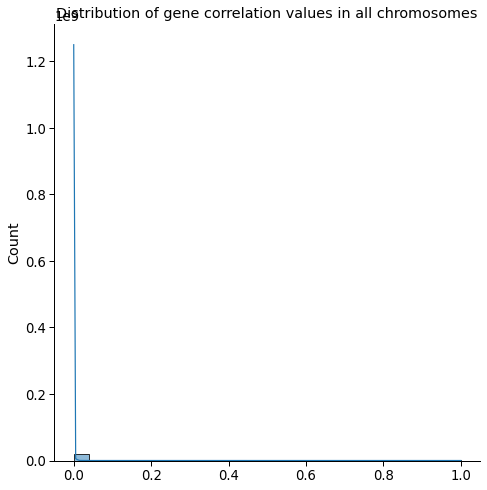

In [54]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(_corr_mat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")

### Plot: heatmap

In [55]:
vmin_val = 0.0
vmax_val = max(0.05, _corr_mat.quantile(0.99))
display(f"{vmin_val} / {vmax_val}")

'0.0 / 0.05'

Text(0.5, 1.0, 'Gene correlations in all chromosomes')

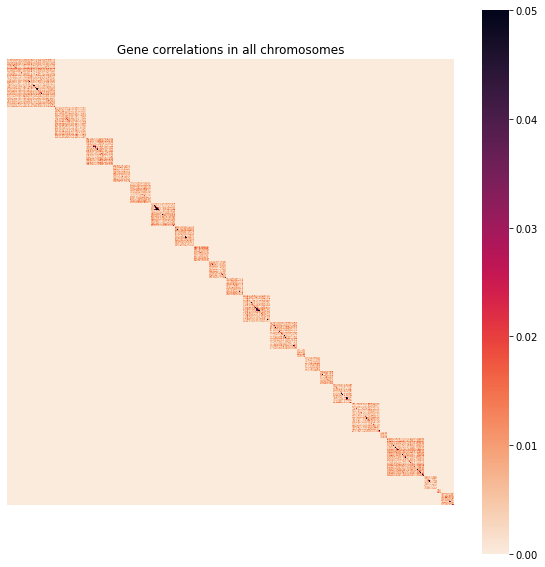

In [56]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    full_corr_matrix,
    xticklabels=False,
    yticklabels=False,
    square=True,
    vmin=vmin_val,
    vmax=vmax_val,
    cmap="rocket_r",
    ax=ax,
)
ax.set_title("Gene correlations in all chromosomes")

## On nonzero correlations

In [57]:
nonzero_corrs = full_corr_matrix_flat[full_corr_matrix_flat > 0.0]

In [58]:
_corr_mat = nonzero_corrs

In [59]:
_corr_mat.shape

(1178737,)

In [60]:
_corr_mat.head()

ENSG00000188290  ENSG00000188976    0.111648
ENSG00000187608  ENSG00000188976    0.187064
                 ENSG00000188290    0.760347
ENSG00000188157  ENSG00000188976    0.083062
                 ENSG00000188290    0.394843
dtype: float64

In [61]:
_corr_mat.describe().apply(str)

count                1178737.0
mean      0.008209100625685212
std       0.028325428653142557
min      1.772568775271758e-10
25%       0.003715984626143291
50%       0.005735987283175417
75%       0.008067026953006302
max         0.9999975042224853
dtype: object

In [62]:
display(_corr_mat.quantile(np.arange(0, 1, 0.05)))

0.00    1.772569e-10
0.05    1.449333e-03
0.10    2.192049e-03
0.15    2.768914e-03
0.20    3.267172e-03
0.25    3.715985e-03
0.30    4.139756e-03
0.35    4.544780e-03
0.40    4.940980e-03
0.45    5.337907e-03
0.50    5.735987e-03
0.55    6.146002e-03
0.60    6.571381e-03
0.65    7.029993e-03
0.70    7.522980e-03
0.75    8.067027e-03
0.80    8.699646e-03
0.85    9.473720e-03
0.90    1.051994e-02
0.95    1.232708e-02
dtype: float64

In [63]:
display(_corr_mat.quantile(np.arange(0, 0.001, 0.0001)))

0.0000    1.772569e-10
0.0001    1.377658e-06
0.0002    4.361721e-06
0.0003    8.485476e-06
0.0004    1.294010e-05
0.0005    1.772191e-05
0.0006    2.349546e-05
0.0007    2.977675e-05
0.0008    3.509236e-05
0.0009    4.026155e-05
dtype: float64

In [64]:
display(_corr_mat.quantile(np.arange(0.999, 1.0, 0.0001)))

0.9990    0.496640
0.9991    0.515398
0.9992    0.534244
0.9993    0.558116
0.9994    0.578373
0.9995    0.607361
0.9996    0.641940
0.9997    0.677050
0.9998    0.707566
0.9999    0.793635
1.0000    0.999998
dtype: float64

### Plot: distribution

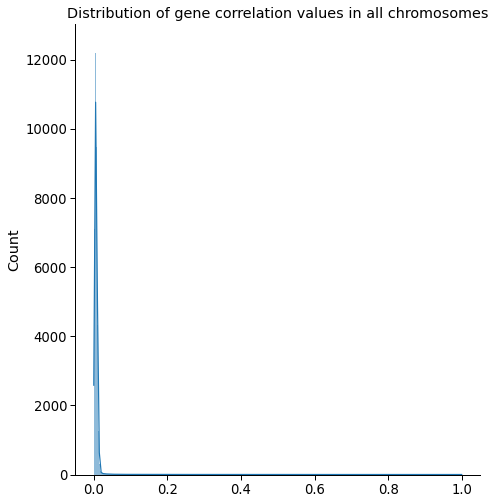

In [65]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(_corr_mat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")